<a href="https://colab.research.google.com/github/ksg98/AI-generated-Content-writing-using-GPT-neo-and-gradioand-/blob/main/ECS289G_RNN_CTC_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

# Upload kaggle.json
files.upload()

# Set up Kaggle directory and API key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle

# Download and unzip Handwriting BCI dataset
!kaggle datasets download -d saurabhshahane/handwriting-bci
!unzip handwriting-bci.zip

Streaming output truncated to the last 5000 lines.
  inflating: handwritingBCIData/RNNTrainingSteps/Step6_ApplyBigramLM/HeldOutTrials/KaldiOutput/t5.2019.12.20/21_transcript.txt  
  inflating: handwritingBCIData/RNNTrainingSteps/Step6_ApplyBigramLM/HeldOutTrials/KaldiOutput/t5.2019.12.20/21_words_dec.ark  
  inflating: handwritingBCIData/RNNTrainingSteps/Step6_ApplyBigramLM/HeldOutTrials/KaldiOutput/t5.2019.12.20/22_align_dec.ark  
  inflating: handwritingBCIData/RNNTrainingSteps/Step6_ApplyBigramLM/HeldOutTrials/KaldiOutput/t5.2019.12.20/22_best_acscore.ark  
  inflating: handwritingBCIData/RNNTrainingSteps/Step6_ApplyBigramLM/HeldOutTrials/KaldiOutput/t5.2019.12.20/22_best_ali.ark  
  inflating: handwritingBCIData/RNNTrainingSteps/Step6_ApplyBigramLM/HeldOutTrials/KaldiOutput/t5.2019.12.20/22_best_dec.ark  
  inflating: handwritingBCIData/RNNTrainingSteps/Step6_ApplyBigramLM/HeldOutTrials/KaldiOutput/t5.2019.12.20/22_best_lmscore.ark  
  inflating: handwritingBCIData/RNNTrainingSteps

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

from sklearn.preprocessing import LabelEncoder

import string

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import argparse
import os
from pathlib import Path
import time
import sys

from dateutil.parser import parse as dtparse
import numpy as np
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

MATPLOTLIB_COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]



## NOTES

### RNN:

#### Overfitting:


* decrease the learning rate
* weight decay in optimizer
* dropout layers during training
* batch normalization





Streaming output truncated to the last 5000 lines.
epoch: 907 batch: 22
epoch: 907 batch: 23
epoch: 907 batch: 24
epoch: 907 batch: 25
epoch: 907 batch: 26
epoch: 907 batch: 27
epoch: 907 batch: 28
epoch: 907 batch: 29
epoch: 907 batch: 30
epoch: 907 batch: 31
epoch: 907 batch: 32
epoch: 907 batch: 33
epoch: 907 batch: 34
epoch: 907 batch: 35
epoch: 907 batch: 36
epoch: 907 batch: 37
epoch: 907 batch: 38
epoch: 907 batch: 39
epoch: 907 batch: 40
epoch: 907 batch: 41
epoch: 907 batch: 42
epoch: 907 batch: 43
epoch: 907 batch: 44
epoch: 907 batch: 45
epoch: 907 batch: 46
epoch: 907 batch: 47
epoch: 907 batch: 48
epoch: 907 batch: 49
epoch: 907 batch: 50
epoch: 907 batch: 51
Epoch 908/1000, Loss: 0.0091, Train Accuracy: 100.00%
Epoch 908/1000, Loss: 0.0091, Test Accuracy: 86.34%
epoch: 908 batch: 0
epoch: 908 batch: 1
epoch: 908 batch: 2
epoch: 908 batch: 3
epoch: 908 batch: 4
epoch: 908 batch: 5
epoch: 908 batch: 6
epoch: 908 batch: 7
epoch: 908 batch: 8
epoch: 908 batch: 9
epoch: 908 ba

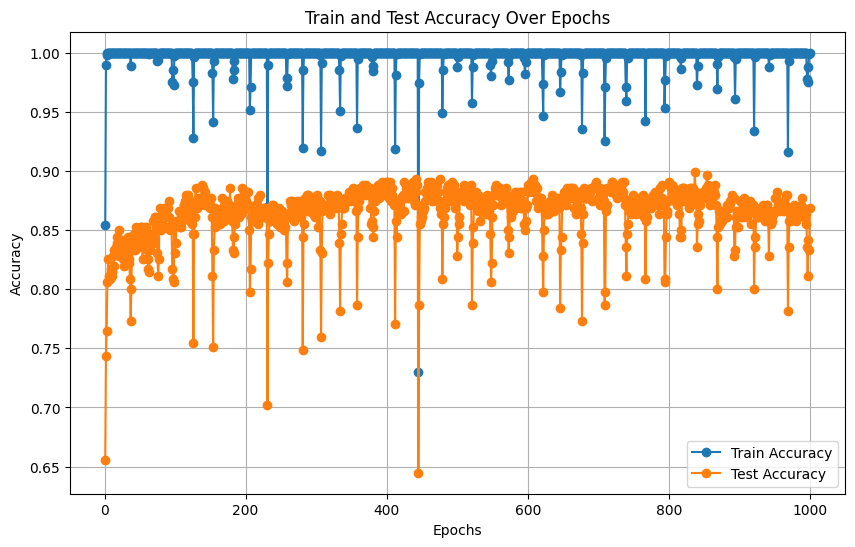

Test Accuracy: 86.89%


In [ ]:

########################################################################################
# Main function.
########################################################################################
ALL_CHARS = [
    "doNothing",
    *string.ascii_lowercase,
    "greaterThan",
    "tilde",
    "questionMark",
    "apostrophe",
    "comma",
]

# hyperparams
INPUT_SIZE=192 # electrode input
SEQUENCE_LENGTH=90 # time bins
NUM_LAYERS=2
HIDDEN_SIZE=128
NUM_CLASSES=len(ALL_CHARS)
LEARNING_RATE=0.0005
BATCH_SIZE=64
NUM_EPOCHS=1000

def main():

    show_plots = True

    ## Load the data.

    data_dicts = load_data()

    # ## Visualize the neural data.

    # visualize_neural_data(data_dicts)
    # return

    ## Create labeled pairs.

    train_dataset, test_dataset = organize_data(data_dicts)

    ## Train the RNN
    # initialize the model
    model = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES, SEQUENCE_LENGTH).to(device)

    # loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)

    # run the train
    train_neural_network(model, train_dataset, test_dataset, NUM_EPOCHS, criterion, optimizer, BATCH_SIZE)

    ## Evaluate the model
    # Calculate training accuracy
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_accuracy = calculate_accuracy(model, test_dataloader)

    # Print metrics
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


if __name__ == "__main__":
    main()


In [ ]:

########################################################################################
# Helper functions.
########################################################################################


def load_data():
    """
    Scrape the data directory and load the data files from disk into dicts in memory.
    """
    # Specify the path to the dataset directory
    DATA_DIR = os.path.abspath("/content/handwritingBCIData/Datasets/")
    letters_filepaths = []

    # Iterate through the files in the dataset directory
    for root, _, filenames in os.walk(DATA_DIR):
        for filename in filenames:
            filepath = os.path.join(root, filename)
            if filename == "singleLetters.mat":
                letters_filepaths.append(filepath)

    letters_filepaths = sorted(letters_filepaths)

    data_dicts = []
    for filepath in letters_filepaths:
        print(f"Loading {filepath} ...")
        data_dict = loadmat(filepath)
        data_dicts.append(data_dict)
        # break  # for testing quickly

    return data_dicts


def visualize_neural_data(data_dicts):
    """"""

    print("Visualizing the neural data ...")

    num_plots = len(data_dicts)
    num_cols = int(np.ceil(np.sqrt(num_plots)))
    num_rows = int(np.ceil(num_plots / num_cols))

    fig, axs = plt.subplots(num_rows, num_cols)

    if type(axs) != np.ndarray:
        axs = np.array([[axs]])

    for session_idx, data_dict in enumerate(data_dicts):
        session_date = dtparse(data_dict["blockStartDates"][0][0][0]).date()

        timestamps = data_dict["clockTimeSeries"]
        bin_lengths = np.diff(timestamps.flatten())
        real_bin_lengths = bin_lengths[bin_lengths > 0]
        bin_length_sec = np.round(np.mean(real_bin_lengths), 4)

        neural_activity = data_dict["neuralActivityTimeSeries"]
        delay_cue_bins = data_dict["delayPeriodOnsetTimeBin"]
        go_cue_bins = data_dict["goPeriodOnsetTimeBin"]
        prompts = data_dict["characterCues"]

        NUM_PCS = 3
        pca_model = PCA(n_components=NUM_PCS)
        pca_neural_activity = pca_model.fit_transform(neural_activity)

        row_idx = session_idx // num_cols
        col_idx = session_idx % num_cols

        ax = axs[row_idx, col_idx]

        neural_sum = np.sum(neural_activity, axis=1)
        smoothed_neural_sum = gaussian_filter1d(neural_sum, 5)
        (sum_line,) = ax.plot(
            smoothed_neural_sum,
            color=MATPLOTLIB_COLORS[0],
            linestyle="--",
            label="summed activity",
        )

        pc_ax = ax.twinx()
        pca_lines = []
        smoothed_pca_neural_activity = gaussian_filter1d(pca_neural_activity, 5, axis=0)
        for i in range(NUM_PCS):
            (pca_line,) = pc_ax.plot(
                smoothed_pca_neural_activity[:, i],
                color=MATPLOTLIB_COLORS[i + 1],
                alpha=0.5,
                label=f"PC {i + 1}",
            )
            pca_lines.append(pca_line)

        pca_avg = np.mean(smoothed_pca_neural_activity, axis=1)
        (pca_avg_line,) = pc_ax.plot(
            pca_avg,
            color=MATPLOTLIB_COLORS[NUM_PCS + 1],
            linewidth=2,
            label="PC avg",
        )

        for delay_cue_bin in delay_cue_bins:
            ax.axvline(delay_cue_bin, color="orange")

        for go_cue_bin in go_cue_bins:
            ax.axvline(go_cue_bin, color="green")

        ax.set_xlabel("time bin")
        ax.set_ylabel("threshold crossings")

        ax.set_title(f"session {session_date}")

        legend_lines = [sum_line, *pca_lines, pca_avg_line]
        legend_labels = [
            sum_line.get_label(),
            *[pca_line.get_label() for pca_line in pca_lines],
            pca_avg_line.get_label(),
        ]
        ax.legend(legend_lines, legend_labels)

    fig.set_figwidth(16)
    fig.set_figheight(10)

    plt.tight_layout()

    plt.show()

# def organize_data(data_dicts):
#     """
#     Take the dicts of session data, slice up trials to get inputs and labels, and split
#     these data into train and test portions.
#     """
#     REACTION_TIME_BINS = 10
#     TRAINING_WINDOW_BINS = 90

#     print("Organizing data ...")

#     data_dict = data_dicts[0]

#     neural = data_dict["neuralActivityTimeSeries"]
#     go_cue_bins = data_dict["goPeriodOnsetTimeBin"].ravel().astype(int)
#     prompts = np.array([a[0] for a in data_dict["characterCues"].ravel()])
#     block_by_bin = data_dict["blockNumsTimeSeries"].ravel()
#     block_nums = data_dict["blockList"].ravel()

#     X_train = []
#     X_test = []
#     y_train = []
#     y_test = []

#     # Iterate through each block.
#     for block_num in block_nums:
#         # Get means and stddevs from the first 75% of trials in the block, since we will
#         # use those trials for training, and use later trials to validate and test on.
#         block_trial_mask = [block_by_bin[b] == block_num for b in go_cue_bins]
#         block_go_cue_bins = go_cue_bins[block_trial_mask]
#         block_prompts = prompts[block_trial_mask]
#         num_trials_in_block = sum(block_trial_mask)
#         last_train_trial = int(num_trials_in_block * 0.80)
#         # These start and end bins are not exact, but they give us a range solidly
#         # within the training trials.
#         neural_to_zscore_based_on = neural[
#             block_go_cue_bins[0] : block_go_cue_bins[last_train_trial - 1]
#         ]
#         block_means = np.mean(neural_to_zscore_based_on, axis=0)
#         block_stddevs = np.std(neural_to_zscore_based_on, axis=0)

#         print(f"Creating labeled pairs for block {block_num} ...")
#         for trial_idx in range(num_trials_in_block):
#             # Get the training window for this trial.
#             go_cue_bin = block_go_cue_bins[trial_idx]
#             window_start_bin = int(go_cue_bin) + REACTION_TIME_BINS
#             window_end_bin = window_start_bin + TRAINING_WINDOW_BINS
#             # Get the neural data in this window.
#             trial_neural = neural[window_start_bin:window_end_bin]
#             # Z-score the neural data using the block-specific means and stddevs.
#             with np.errstate(divide="ignore", invalid="ignore"):
#                 trial_zscored_neural = (trial_neural - block_means) / block_stddevs
#             trial_zscored_neural = np.nan_to_num(
#                 trial_zscored_neural, nan=0, posinf=0, neginf=0
#             )

#             # Get the character for this trial.
#             trial_label = block_prompts[trial_idx]

#             # Add the trial to the appropriate set of data (train, validation, or test).
#             if trial_idx < last_train_trial:
#                 X_train.append(trial_zscored_neural)
#                 y_train.append(trial_label)
#             else:
#                 X_test.append(trial_zscored_neural)
#                 y_test.append(trial_label)

#     X_train = np.array(X_train)
#     X_test = np.array(X_test)
#     y_train = np.array(y_train)
#     y_test = np.array(y_test)

#     # Encode string labels into numeric format
#     label_encoder = LabelEncoder()
#     y_train_encoded = label_encoder.fit_transform(y_train)
#     y_test_encoded = label_encoder.fit_transform(y_test)

#     # Convert NumPy arrays to PyTorch tensors
#     X_train_tensor = torch.FloatTensor(X_train)
#     y_train_tensor = torch.LongTensor(y_train_encoded)
#     X_test_tensor = torch.FloatTensor(X_test)
#     y_test_tensor = torch.LongTensor(y_test_encoded)

#     # Create Tensor datasets
#     train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#     test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

#     print(f"X_train: {X_train.shape}")
#     print(f"X_test: {X_test.shape}")
#     print(f"y_train: {y_train.shape}")
#     print(f"y_test: {y_test.shape}")

#     return train_dataset, test_dataset


def organize_data(data_dicts):
    """
    Take the dicts of session data, slice up trials to get inputs and labels, and split
    these data into train and test portions.
    """

    print("Organizing data ...")

    REACTION_TIME_NUM_BINS = 10
    TRAINING_WINDOW_NUM_BINS = 90

    input_tensors = []
    labels = []
    for session_idx, data_dict in enumerate(data_dicts):
        neural_activity = data_dict["neuralActivityTimeSeries"]
        delay_cue_bins = data_dict["delayPeriodOnsetTimeBin"].ravel().astype(int)
        go_cue_bins = data_dict["goPeriodOnsetTimeBin"].ravel().astype(int)
        prompts = [a[0] for a in data_dict["characterCues"].ravel()]

        print(f"Creating training pairs for session {session_idx} ...")
        for trial_idx, go_cue_bin in enumerate(go_cue_bins):
            # Get the training window for this trial.
            training_window_start_bin = int(go_cue_bin) + REACTION_TIME_NUM_BINS
            training_window_end_bin = (
                training_window_start_bin + TRAINING_WINDOW_NUM_BINS
            )
            training_window_neural_activity = neural_activity[
                training_window_start_bin:training_window_end_bin
            ]
            # Make a separate feature out of every (feature, timestep) pair.

            input_tensor = training_window_neural_activity

            label = prompts[trial_idx]

            input_tensors.append(input_tensor)
            labels.append(label)

    input_tensors = np.array(input_tensors)
    labels = np.array(labels)

    X_train, X_test, y_train, y_test = train_test_split(
        input_tensors,
        labels,
        test_size=0.1,
        shuffle=True,
    )

    # Encode string labels into numeric format
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.fit_transform(y_test)

    # Convert NumPy arrays to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train_encoded)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test_encoded)

    # Create Tensor datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    print(f"X_train: {X_train.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")

    return train_dataset, test_dataset

In [ ]:
def train_neural_network(model, train_dataset, test_dataset, num_epochs, criterion, optimizer, batch_size):
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

  train_accuracies = []
  test_accuracies = []
  for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_dataloader):
      print(f"epoch: {epoch} batch: {batch_idx}")
      # Add noise to the input data
      data_noisy = add_noise(data)

      data_noisy = data_noisy.to(device=device).squeeze(1)
      targets = targets.to(device=device)

      # forward
      scores = model(data_noisy)  # Compute predictions (scores) using the neural network
      loss = criterion(scores, targets)  # Compute the loss between predicted and true labels

      # backward
      optimizer.zero_grad()  # Zero the gradients to avoid accumulation
      loss.backward()  # Compute gradients of the loss with respect to model parameters

      # gradient descent
      optimizer.step()  # Update model parameters using the computed gradients

    # Calculate accuracy
    train_accuracy = calculate_accuracy(model, train_dataloader)
    test_accuracy = calculate_accuracy(model, test_dataloader)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    # Print metrics
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

  # Plotting
  plot_accuracy(train_accuracies, test_accuracies, num_epochs)

def plot_accuracy(train_accuracies, test_accuracies, num_epochs):
    epochs = list(range(1, num_epochs + 1))

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

def add_noise(data, noise_std=0.05, scale=1):
    noise = noise_std * scale * torch.randn_like(data)
    return data + noise

def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in dataloader:
            data, targets = data.to(device=device), targets.to(device=device)

            # Forward pass
            scores = model(data)
            _, predictions = scores.max(1)

            # Update counts
            total += targets.size(0)
            correct += (predictions == targets).sum().item()

    accuracy = correct / total
    return accuracy




class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes, sequence_length):
      super(RNN, self).__init__()
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
      self.batch_norm = nn.BatchNorm1d(hidden_size * sequence_length)
      self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

  def forward(self, x):
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

      # forward prop
      out, _ = self.rnn(x, h0)
      out = out.reshape(out.shape[0], -1)
      out = self.batch_norm(out)
      out = self.fc(out)

      return out
